In [31]:
#pip install tensorflow transformers
#pip install tensorflow scikit-learn
#!jupyter notebook -W ignore
#!pip install kaggle
# !pip install --upgrade tensorflow_hub
#!pip install -U "tensorflow-text==2.13.*"
#pip install -U 'https://files.pythonhosted.org/packages/a8/df/c7c5c15af9b769dfbede372f8e9165e58ed113cddef2abbf5b4bf2fe9aa5/tf_models_official-2.14.2-py2.py3-none-any.whl'
#!pip install --upgrade protobuf
#pip install tensorflow-text
#!pip install pydot
#!pip install graphviz

## 1. Libraries Import

In [ ]:
import tensorflow as tf
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Input, Lambda, Dense
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_text as text
import kaggle
import zipfile
import os
import pandas as pd
import random
import math
import tensorflow_hub as hub
from official.nlp import optimization
import matplotlib.pyplot as plt
import pydot
import graphviz
import warnings 
warnings.filterwarnings('ignore')

## 2.Data Import and Preprocessing

In [ ]:
!kaggle datasets download -d bigddang/nlp-project-paraphrase-detection

In [4]:
filepath='./nlp-project-paraphrase-detection.zip'
folder='./dataset/nlp-project-paraphrase-detection'

os.makedirs(folder, exist_ok=True)

# Open the zip file
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(folder)

print(f"Folder '{filepath}' successfully extracted to '{folder}'.")

Folder './nlp-project-paraphrase-detection.zip' successfully extracted to './dataset/nlp-project-paraphrase-detection'.


In [5]:
df_train=pd.read_csv('./dataset/nlp-project-paraphrase-detection/trainf.tsv',sep='\t')
df_val=pd.read_csv('./dataset/nlp-project-paraphrase-detection/devf.tsv',sep='\t')
df_test=pd.read_csv('./dataset/nlp-project-paraphrase-detection/testf.tsv',sep='\t')

train_nan=df_train.isnull().values.any()
val_nan=df_val.isnull().values.any()
test_nan=df_test.isnull().values.any()
print(train_nan, val_nan,test_nan)

True True True


In [6]:
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)
df_val.dropna(inplace=True)

In [7]:
df_train.head()
#abslen(df_train)

,Quality,#1 ID,#2 ID,#1 String,#2 String
0,1,702876,702977,"Amrozi accused his brother, whom he called ""th...","Referring to him as only ""the witness"", Amrozi..."
1,0,2108705,2108831,Yucaipa owned Dominick's before selling the ch...,Yucaipa bought Dominick's in 1995 for $693 mil...
2,1,1330381,1330521,They had published an advertisement on the Int...,"On June 10, the ship's owners had published an..."
3,0,3344667,3344648,"Around 0335 GMT, Tab shares were up 19 cents, ...","Tab shares jumped 20 cents, or 4.6%, to set a ..."
4,1,1236820,1236712,"The stock rose $2.11, or about 11 percent, to ...",PG&E Corp. shares jumped $1.63 or 8 percent to...


In [8]:
df_val.head()
#len(df_val)

,Quality,#1 ID,#2 ID,#1 String,#2 String
0,1,1479718,1479546,Stocks have rallied sharply for more than thre...,Stocks have rallied sharply for more than thre...
1,0,1091286,1091304,The Fed's Empire State survey far exceeded exp...,Prices had pulled back from offshore highs whe...
2,1,2158854,2158971,"Druce will face murder charges, Conte said.",Conte said Druce will be charged with murder.
3,1,2086152,2086347,"We're a quiet, peaceful town of 862 people and...","We're a quiet, peaceful town of 862 people and..."
4,0,3107641,3107862,"Nursing schools turned away more than 5,000 qu...",The American Association of Nursing Colleges r...


In [9]:
df_test.head()
#len(df_test)

,Quality,#1 ID,#2 ID,#1 String,#2 String
0,1,1089874,1089925,"PCCW's chief operating officer, Mike Butcher, ...",Current Chief Operating Officer Mike Butcher a...
1,1,3019446,3019327,The world's two largest automakers said their ...,Domestic sales at both GM and No. 2 Ford Motor...
2,1,1945605,1945824,According to the federal Centers for Disease C...,The Centers for Disease Control and Prevention...
3,0,1430402,1430329,A tropical storm rapidly developed in the Gulf...,A tropical storm rapidly developed in the Gulf...
4,0,3354381,3354396,The company didn't detail the costs of the rep...,But company officials expect the costs of the ...


In [10]:
df_train.dtypes

Quality       int64
#1 ID         int64
#2 ID         int64
#1 String    object
#2 String    object
dtype: object

In [11]:
features=['#1 String','#2 String']

In [12]:
train_data = tf.data.Dataset.from_tensor_slices(( tf.cast("[CLS]" + df_train[features].apply("[Sep]".join, axis=1).values, tf.string),
                                                     tf.cast(df_train['Quality'].values, tf.int32)))

print(train_data.element_spec)
for i,j in train_data.take(5):
    print(i.numpy(), j.numpy())

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))
b'[CLS]Amrozi accused his brother, whom he called "the witness", of deliberately distorting his evidence.[Sep]Referring to him as only "the witness", Amrozi accused his brother of deliberately distorting his evidence.' 1
b"[CLS]Yucaipa owned Dominick's before selling the chain to Safeway in 1998 for $2.5 billion.[Sep]Yucaipa bought Dominick's in 1995 for $693 million and sold it to Safeway for $1.8 billion in 1998." 0
b"[CLS]They had published an advertisement on the Internet on June 10, offering the cargo for sale, he added.[Sep]On June 10, the ship's owners had published an advertisement on the Internet, offering the explosives for sale." 1
b'[CLS]Around 0335 GMT, Tab shares were up 19 cents, or 4.4%, at A$4.56, having earlier set a record high of A$4.57.[Sep]Tab shares jumped 20 cents, or 4.6%, to set a record closing high at A$4.57.' 0
b'[CLS]The stock rose $2.11, or about 11 percent

In [13]:
test_data = tf.data.Dataset.from_tensor_slices(( tf.cast("[CLS]" + df_test[features].apply("[Sep]".join, axis=1).values, tf.string),
                                                     tf.cast(df_test['Quality'].values, tf.int32)))
val_data = tf.data.Dataset.from_tensor_slices(( tf.cast("[CLS]" + df_val[features].apply("[Sep]".join, axis=1).values, tf.string),
                                                     tf.cast(df_val['Quality'].values, tf.int32)))

In [14]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

def prepare_dataset(dataset, is_train=False):
    if is_train:
        # Shuffle and batch the training dataset
        dataset = dataset.shuffle(BUFFER_SIZE)
    return dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Preparing datasets
train_data = prepare_dataset(train_data, is_train=True)
val_data = prepare_dataset(val_data)
test_data= prepare_dataset(test_data)


## 3. Model and Training

In [15]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]



print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [16]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

In [17]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

bert_results = bert_model(text_preprocessed)

In [18]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [19]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.18725833]], shape=(1, 1), dtype=float32)


In [32]:
tf.keras.utils.plot_model(classifier_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [21]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [22]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = [tf.metrics.BinaryAccuracy(), f1_m]

In [23]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_data).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [24]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)


In [25]:
history = classifier_model.fit(x=train_data,
                               validation_data=val_data,
                               epochs=epochs)

Epoch 1/10
56/56 [==============================] - 344s 6s/step - loss: 0.6281 - binary_accuracy: 0.6049 - f1_m: 0.6549 - val_loss: 0.5555 - val_binary_accuracy: 0.7128 - val_f1_m: 0.7967
Epoch 2/10
56/56 [==============================] - 320s 6s/step - loss: 0.5462 - binary_accuracy: 0.7076 - f1_m: 0.7730 - val_loss: 0.5075 - val_binary_accuracy: 0.7515 - val_f1_m: 0.8196
Epoch 3/10
56/56 [==============================] - 329s 6s/step - loss: 0.4516 - binary_accuracy: 0.7798 - f1_m: 0.8297 - val_loss: 0.4822 - val_binary_accuracy: 0.7841 - val_f1_m: 0.8467
Epoch 4/10
56/56 [==============================] - 329s 6s/step - loss: 0.3709 - binary_accuracy: 0.8282 - f1_m: 0.8681 - val_loss: 0.4661 - val_binary_accuracy: 0.7780 - val_f1_m: 0.8341
Epoch 5/10
56/56 [==============================] - 340s 6s/step - loss: 0.2987 - binary_accuracy: 0.8670 - f1_m: 0.8948 - val_loss: 0.4877 - val_binary_accuracy: 0.7800 - val_f1_m: 0.8325
Epoch 6/10
56/56 [==============================] - 404

In [28]:
loss, accuracy, f1 = classifier_model.evaluate(test_data)

print(f'F1: {f1}')
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


27/27 [==============================] - 50s 2s/step - loss: 0.7292 - binary_accuracy: 0.7555 - f1_m: 0.8144
F1: 0.8143541812896729
Loss: 0.7291502952575684
Accuracy: 0.7554895877838135


dict_keys(['loss', 'binary_accuracy', 'f1_m', 'val_loss', 'val_binary_accuracy', 'val_f1_m'])


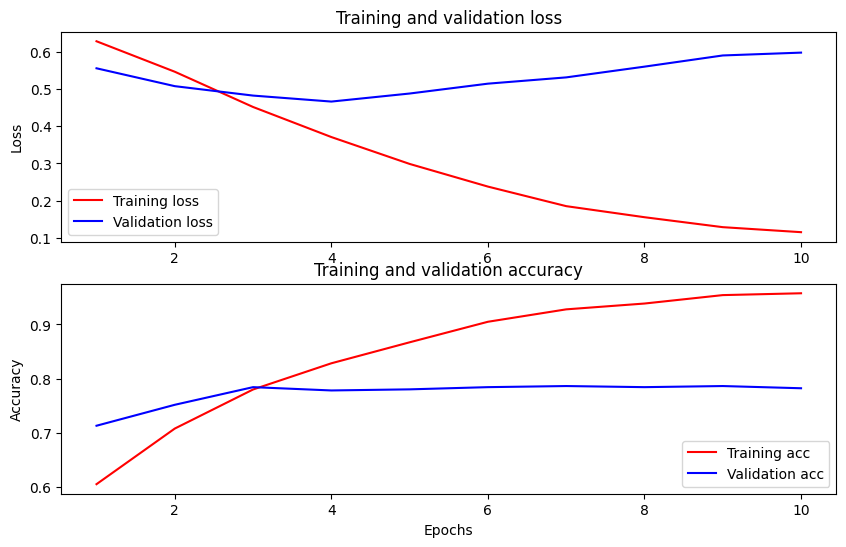

In [29]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')